In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import os
from PIL import Image 
import tensorflow as tf
import keras.backend as K
from keras.applications import Xception
from keras.layers import UpSampling2D, Conv2D, Activation, LeakyReLU, BatchNormalization
from keras import Model
from keras.losses import binary_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from tqdm import tqdm_notebook

Using TensorFlow backend.


### The Data

In [2]:
df_train = pd.read_csv('./input/severstal-steel-defect-detection/train.csv')

In [3]:
df_train['Defect'] = df_train['EncodedPixels'].notnull()
df_train['ClassId'] = df_train['ImageId_ClassId'].str[-1:]
df_train['ImageId'] = df_train['ImageId_ClassId'].str[:-2]

df_train = df_train[['ImageId','ClassId','Defect','EncodedPixels']]

In [4]:
df_train = df_train[df_train.Defect]
df_train = df_train.drop(['Defect'], axis=1)

In [5]:
df_train.shape

(7095, 3)

In [6]:
df_train.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
18,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
20,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
27,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
30,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


### Utility functions

In [7]:
# This function uses a 0 based start index (arrays, matrixes and imgs start a index 0)
def mask2rle(img):
    tmp = np.rot90( np.flipud( img ), k=3 )
    rle = []
    lastColor = 0;
    startpos = 0
    endpos = 0

    tmp = tmp.reshape(-1,1)   
    for i in range( len(tmp) ):
        if (lastColor==0) and tmp[i]>0:
            startpos = i
            lastColor = 1
        elif (lastColor==1)and(tmp[i]==0):
            endpos = i-1
            lastColor = 0
            rle.append( str(startpos)+' '+str(endpos-startpos+1) )
    return " ".join(rle)

In [8]:
img = [
    [0, 1, 0, 0, 0],
    [0, 1, 1, 1, 0], 
    [0, 1, 0, 1, 0],
    [0, 1, 1, 1, 0], 
    [0, 0, 0, 1, 0],
]

res = mask2rle(img)
print(res)

5 4 11 1 13 1 16 4


In [9]:
# This function uses a 0 based start index (arrays, matrixes and imgs start a index 0)
def rle2mask(rle, width, height):
    width = width
    height= height
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )

In [10]:
res = rle2mask("5 4 11 1 13 1 16 4", 5, 5)
print(res)

[[0 1 0 0 0]
 [0 1 1 1 0]
 [0 1 0 1 0]
 [0 1 1 1 0]
 [0 0 0 1 0]]


### Xception Model in Keras

In [12]:
ORIG_IMG_SIZE_HEIGHT = 256
ORIG_IMG_SIZE_WIDTH = 1600
TRAIN_IMG_SIZE_HEIGHT = 64
TRAIN_IMG_SIZE_WIDTH = 400

NO_OF_CLASSES = 4

BATCH_SIZE = 4


In [13]:
import keras

class DataGenerator(keras.utils.Sequence):
    def __init__(self, df, img_path, orig_img_shape, new_img_shape=None, batch_size = BATCH_SIZE, n_channels=1,
                 n_classes=4, shuffle=False):
        super().__init__()
        self.df = df
        self.img_path = img_path
        self.orig_img_shape = orig_img_shape
        if new_img_shape:
            self.new_img_shape = new_img_shape
        else:
            self.new_img_shape = orig_img_shape
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index): 
        X = np.empty((self.batch_size, *self.new_img_shape, self.n_channels), dtype=np.uint8)
        y = np.empty((self.batch_size, *self.new_img_shape, 1), dtype=np.uint8)
        
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        for idx, filename in enumerate(self.df['ImageId'].iloc[indexes]):
            img = cv2.imread(self.img_path + filename, cv2.IMREAD_UNCHANGED)
            if self.orig_img_shape != self.new_img_shape:
                img = cv2.resize(img, tuple(reversed(self.new_img_shape)), interpolation=cv2.INTER_AREA)
            X[idx,] = img
            
            mask_i = rle2mask(self.df['EncodedPixels'].iloc[indexes[idx]], *self.orig_img_shape)            
            img_mask_i = Image.fromarray(mask_i, 'L')
            img_mask_np = np.array(img_mask_i) 
            
            if self.orig_img_shape != self.new_img_shape:
                img_mask_np = cv2.resize(img_mask_np, tuple(reversed(self.new_img_shape)), interpolation=cv2.INTER_AREA)
            y[idx,:,:,0] = img_mask_np
            
        return X, y

In [14]:
def dice_coeff(y_true, y_pred):
    smooth = 1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    loss = 0.5 * binary_crossentropy(y_true, y_pred) - 2*dice_coeff(y_true, y_pred)
    return loss


In [15]:
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization

def advanced_unet_64x400_segmentation_model(input_shape=(64, 400, 3), num_classes=1):
    inputs = Input(shape=input_shape) # 256

    down0 = Conv2D(32, (3, 3), padding='same')(inputs)
    down0 = BatchNormalization()(down0)
    down0 = Activation('relu')(down0)
    down0 = Conv2D(32, (3, 3), padding='same')(down0)
    down0 = BatchNormalization()(down0)
    down0 = Activation('relu')(down0)
    down0_pool = MaxPooling2D((2, 2), strides=(2, 2))(down0) # 128

    down1 = Conv2D(64, (3, 3), padding='same')(down0_pool)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1 = Conv2D(64, (3, 3), padding='same')(down1)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1) # 64

    down2 = Conv2D(128, (3, 3), padding='same')(down1_pool)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2 = Conv2D(128, (3, 3), padding='same')(down2)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2_pool = MaxPooling2D((2, 2), strides=(2, 2))(down2) # 32

    down3 = Conv2D(256, (3, 3), padding='same')(down2_pool)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3 = Conv2D(256, (3, 3), padding='same')(down3)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3_pool = MaxPooling2D((2, 2), strides=(2, 2))(down3) # 16

    down4 = Conv2D(512, (3, 3), padding='same')(down3_pool)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4 = Conv2D(512, (3, 3), padding='same')(down4)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4_pool = MaxPooling2D((2, 1), strides=(2, 1))(down4) # 8

    center = Conv2D(1024, (3, 3), padding='same')(down4_pool)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    center = Conv2D(1024, (3, 3), padding='same')(center)
    center = BatchNormalization()(center)
    center = Activation('relu')(center) # center

    up4 = UpSampling2D((2, 1))(center)
    up4 = concatenate([down4, up4], axis=3)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4) # 16

    up3 = UpSampling2D((2, 2))(up4)
    up3 = concatenate([down3, up3], axis=3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3) # 32

    up2 = UpSampling2D((2, 2))(up3)
    up2 = concatenate([down2, up2], axis=3)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2) # 64

    up1 = UpSampling2D((2, 2))(up2)
    up1 = concatenate([down1, up1], axis=3)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1) # 128

    up0 = UpSampling2D((2, 2))(up1)
    up0 = concatenate([down0, up0], axis=3)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0) # 256

    classify = Conv2D(num_classes, (1, 1), activation='sigmoid')(up0)

    model = Model(inputs=inputs, outputs=classify)
    
    return model

In [16]:
advanced_model = advanced_unet_64x400_segmentation_model()
advanced_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 400, 3)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 400, 32)  896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 64, 400, 32)  128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 64, 400, 32)  0           batch_normalization_1[0][0]      
_____________________________________

activation_11 (Activation)      (None, 2, 25, 1024)  0           batch_normalization_11[0][0]     
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 2, 25, 1024)  9438208     activation_11[0][0]              
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 2, 25, 1024)  4096        conv2d_12[0][0]                  
__________________________________________________________________________________________________
activation_12 (Activation)      (None, 2, 25, 1024)  0           batch_normalization_12[0][0]     
__________________________________________________________________________________________________
up_sampling2d_1 (UpSampling2D)  (None, 4, 25, 1024)  0           activation_12[0][0]              
__________________________________________________________________________________________________
concatenat

conv2d_22 (Conv2D)              (None, 32, 200, 64)  110656      concatenate_4[0][0]              
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, 32, 200, 64)  256         conv2d_22[0][0]                  
__________________________________________________________________________________________________
activation_22 (Activation)      (None, 32, 200, 64)  0           batch_normalization_22[0][0]     
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 32, 200, 64)  36928       activation_22[0][0]              
__________________________________________________________________________________________________
batch_normalization_23 (BatchNo (None, 32, 200, 64)  256         conv2d_23[0][0]                  
__________________________________________________________________________________________________
activation

In [17]:
from keras.optimizers import RMSprop

advanced_model.compile(optimizer=RMSprop(lr=0.0003), loss=bce_dice_loss, metrics=[dice_coeff, 'accuracy'])

In [18]:
# A decreasing learning rate schedule (continuous decrease)
def continuous_decay(epoch):
    initial_lrate = 0.01
    lr = initial_lrate * (0.1 ** int(epoch / 10))
    return lr

# Another decreasing learning rate schedule (stepped decrease)
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 5.0
    lr = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lr

def get_callback(patient):
    ES = EarlyStopping(
        monitor='loss', 
        patience=patient, 
        mode='max', 
        verbose=1)
    RR = ReduceLROnPlateau(
        monitor = 'loss', 
        factor = 0.5, 
        patience = patient / 2, 
        min_lr=0.000001, 
        verbose=1, 
        mode='max')
    LR = LearningRateScheduler(
        continuous_decay,
        verbose=1)
    MC = ModelCheckpoint(
        filepath='./Xcep_model_CD_LR0_01.h5', 
        save_best_only=True,
        verbose=1)
#    return [ES, RR, LR, MC]
#    return [ES, MC, RR]
    return [ES, MC, LR]


In [19]:
#TRAIN_IMG_SIZE_HEIGHT = 64
#TRAIN_IMG_SIZE_WIDTH = 400
#BATCH_SIZE = 4

idx = int(0.8*len(df_train))
train_batches = DataGenerator(df_train.iloc[:idx], './input/severstal-steel-defect-detection/train_images/', 
                                    orig_img_shape=(256, 1600), new_img_shape=(TRAIN_IMG_SIZE_HEIGHT, TRAIN_IMG_SIZE_WIDTH), batch_size = BATCH_SIZE, 
                                    n_channels=3, n_classes=4, shuffle=True)
valid_batches = DataGenerator(df_train.iloc[idx:], './input/severstal-steel-defect-detection/train_images/', 
                                    orig_img_shape=(256, 1600), new_img_shape=(TRAIN_IMG_SIZE_HEIGHT, TRAIN_IMG_SIZE_WIDTH), batch_size = BATCH_SIZE, 
                                    n_channels=3, n_classes=4, shuffle=True)

history = advanced_model.fit_generator(train_batches,
                              epochs=4,    
                              validation_data=valid_batches,
                              verbose=1,
                              shuffle=True,
                              callbacks = get_callback(2)
                             )

Instructions for updating:
Use tf.cast instead.
Epoch 1/4

Epoch 00001: LearningRateScheduler setting learning rate to 0.01.


 132/1419 [=>............................] - ETA: 4:25:15 - loss: 0.1990 - dice_coeff: 0.0663 - acc: 0.655 - ETA: 2:14:03 - loss: 0.2483 - dice_coeff: 0.0477 - acc: 0.773 - ETA: 1:30:19 - loss: 0.1470 - dice_coeff: 0.0816 - acc: 0.804 - ETA: 1:08:28 - loss: 0.1142 - dice_coeff: 0.0877 - acc: 0.831 - ETA: 55:20 - loss: 0.0660 - dice_coeff: 0.1048 - acc: 0.8445  - ETA: 46:35 - loss: 0.0468 - dice_coeff: 0.1106 - acc: 0.842 - ETA: 40:20 - loss: 0.0510 - dice_coeff: 0.1045 - acc: 0.836 - ETA: 35:39 - loss: 0.0316 - dice_coeff: 0.1192 - acc: 0.818 - ETA: 32:00 - loss: 0.0205 - dice_coeff: 0.1197 - acc: 0.833 - ETA: 29:05 - loss: 0.0290 - dice_coeff: 0.1129 - acc: 0.840 - ETA: 26:42 - loss: 0.0300 - dice_coeff: 0.1070 - acc: 0.849 - ETA: 24:42 - loss: 0.0223 - dice_coeff: 0.1092 - acc: 0.848 - ETA: 23:01 - loss: 0.0176 - dice_coeff: 0.1077 - acc: 0.856 - ETA: 21:35 - loss: 0.0155 - dice_coeff: 0.1051 - acc: 0.861 - ETA: 20:19 - loss: 0.0083 - dice_coeff: 0.1058 - acc: 0.864 - ETA: 19:14 - lo

 264/1419 [====>.........................] - ETA: 4:33 - loss: -0.2632 - dice_coeff: 0.2098 - acc: 0.908 - ETA: 4:32 - loss: -0.2681 - dice_coeff: 0.2121 - acc: 0.908 - ETA: 4:31 - loss: -0.2678 - dice_coeff: 0.2118 - acc: 0.908 - ETA: 4:30 - loss: -0.2694 - dice_coeff: 0.2128 - acc: 0.908 - ETA: 4:29 - loss: -0.2696 - dice_coeff: 0.2136 - acc: 0.907 - ETA: 4:28 - loss: -0.2766 - dice_coeff: 0.2171 - acc: 0.908 - ETA: 4:27 - loss: -0.2797 - dice_coeff: 0.2185 - acc: 0.908 - ETA: 4:26 - loss: -0.2793 - dice_coeff: 0.2183 - acc: 0.908 - ETA: 4:25 - loss: -0.2809 - dice_coeff: 0.2200 - acc: 0.907 - ETA: 4:25 - loss: -0.2835 - dice_coeff: 0.2213 - acc: 0.907 - ETA: 4:24 - loss: -0.2844 - dice_coeff: 0.2215 - acc: 0.908 - ETA: 4:23 - loss: -0.2861 - dice_coeff: 0.2226 - acc: 0.907 - ETA: 4:22 - loss: -0.2867 - dice_coeff: 0.2230 - acc: 0.907 - ETA: 4:21 - loss: -0.2878 - dice_coeff: 0.2235 - acc: 0.907 - ETA: 4:20 - loss: -0.2871 - dice_coeff: 0.2231 - acc: 0.907 - ETA: 4:19 - loss: -0.2882

 396/1419 [=======>......................] - ETA: 3:17 - loss: -0.4284 - dice_coeff: 0.2909 - acc: 0.917 - ETA: 3:17 - loss: -0.4304 - dice_coeff: 0.2918 - acc: 0.917 - ETA: 3:17 - loss: -0.4315 - dice_coeff: 0.2923 - acc: 0.918 - ETA: 3:16 - loss: -0.4329 - dice_coeff: 0.2930 - acc: 0.918 - ETA: 3:16 - loss: -0.4335 - dice_coeff: 0.2933 - acc: 0.918 - ETA: 3:15 - loss: -0.4342 - dice_coeff: 0.2937 - acc: 0.918 - ETA: 3:15 - loss: -0.4357 - dice_coeff: 0.2945 - acc: 0.918 - ETA: 3:15 - loss: -0.4354 - dice_coeff: 0.2943 - acc: 0.918 - ETA: 3:14 - loss: -0.4369 - dice_coeff: 0.2949 - acc: 0.918 - ETA: 3:14 - loss: -0.4385 - dice_coeff: 0.2956 - acc: 0.918 - ETA: 3:14 - loss: -0.4387 - dice_coeff: 0.2955 - acc: 0.918 - ETA: 3:13 - loss: -0.4417 - dice_coeff: 0.2968 - acc: 0.918 - ETA: 3:13 - loss: -0.4435 - dice_coeff: 0.2977 - acc: 0.918 - ETA: 3:13 - loss: -0.4438 - dice_coeff: 0.2978 - acc: 0.918 - ETA: 3:12 - loss: -0.4450 - dice_coeff: 0.2983 - acc: 0.919 - ETA: 3:12 - loss: -0.4469

 528/1419 [==========>...................] - ETA: 2:40 - loss: -0.5139 - dice_coeff: 0.3294 - acc: 0.924 - ETA: 2:40 - loss: -0.5154 - dice_coeff: 0.3300 - acc: 0.924 - ETA: 2:40 - loss: -0.5162 - dice_coeff: 0.3304 - acc: 0.924 - ETA: 2:40 - loss: -0.5173 - dice_coeff: 0.3310 - acc: 0.924 - ETA: 2:40 - loss: -0.5174 - dice_coeff: 0.3310 - acc: 0.924 - ETA: 2:39 - loss: -0.5174 - dice_coeff: 0.3310 - acc: 0.924 - ETA: 2:39 - loss: -0.5170 - dice_coeff: 0.3308 - acc: 0.924 - ETA: 2:39 - loss: -0.5183 - dice_coeff: 0.3313 - acc: 0.924 - ETA: 2:39 - loss: -0.5191 - dice_coeff: 0.3316 - acc: 0.924 - ETA: 2:38 - loss: -0.5182 - dice_coeff: 0.3313 - acc: 0.924 - ETA: 2:38 - loss: -0.5202 - dice_coeff: 0.3321 - acc: 0.924 - ETA: 2:38 - loss: -0.5216 - dice_coeff: 0.3327 - acc: 0.924 - ETA: 2:38 - loss: -0.5227 - dice_coeff: 0.3331 - acc: 0.924 - ETA: 2:37 - loss: -0.5231 - dice_coeff: 0.3334 - acc: 0.924 - ETA: 2:37 - loss: -0.5238 - dice_coeff: 0.3337 - acc: 0.924 - ETA: 2:37 - loss: -0.5229

 660/1419 [============>.................] - ETA: 2:14 - loss: -0.5696 - dice_coeff: 0.3554 - acc: 0.927 - ETA: 2:13 - loss: -0.5704 - dice_coeff: 0.3558 - acc: 0.927 - ETA: 2:13 - loss: -0.5698 - dice_coeff: 0.3556 - acc: 0.927 - ETA: 2:13 - loss: -0.5699 - dice_coeff: 0.3555 - acc: 0.927 - ETA: 2:13 - loss: -0.5697 - dice_coeff: 0.3554 - acc: 0.927 - ETA: 2:13 - loss: -0.5694 - dice_coeff: 0.3552 - acc: 0.927 - ETA: 2:12 - loss: -0.5694 - dice_coeff: 0.3552 - acc: 0.927 - ETA: 2:12 - loss: -0.5697 - dice_coeff: 0.3554 - acc: 0.928 - ETA: 2:12 - loss: -0.5691 - dice_coeff: 0.3552 - acc: 0.927 - ETA: 2:12 - loss: -0.5691 - dice_coeff: 0.3552 - acc: 0.927 - ETA: 2:12 - loss: -0.5695 - dice_coeff: 0.3554 - acc: 0.927 - ETA: 2:11 - loss: -0.5696 - dice_coeff: 0.3554 - acc: 0.928 - ETA: 2:11 - loss: -0.5696 - dice_coeff: 0.3553 - acc: 0.928 - ETA: 2:11 - loss: -0.5696 - dice_coeff: 0.3553 - acc: 0.928 - ETA: 2:11 - loss: -0.5702 - dice_coeff: 0.3556 - acc: 0.928 - ETA: 2:11 - loss: -0.5707

 792/1419 [===============>..............] - ETA: 1:51 - loss: -0.6077 - dice_coeff: 0.3726 - acc: 0.931 - ETA: 1:50 - loss: -0.6084 - dice_coeff: 0.3729 - acc: 0.931 - ETA: 1:50 - loss: -0.6085 - dice_coeff: 0.3729 - acc: 0.931 - ETA: 1:50 - loss: -0.6093 - dice_coeff: 0.3733 - acc: 0.931 - ETA: 1:50 - loss: -0.6091 - dice_coeff: 0.3732 - acc: 0.931 - ETA: 1:50 - loss: -0.6079 - dice_coeff: 0.3726 - acc: 0.931 - ETA: 1:50 - loss: -0.6088 - dice_coeff: 0.3730 - acc: 0.931 - ETA: 1:49 - loss: -0.6075 - dice_coeff: 0.3726 - acc: 0.930 - ETA: 1:49 - loss: -0.6069 - dice_coeff: 0.3723 - acc: 0.930 - ETA: 1:49 - loss: -0.6074 - dice_coeff: 0.3724 - acc: 0.931 - ETA: 1:49 - loss: -0.6075 - dice_coeff: 0.3724 - acc: 0.931 - ETA: 1:49 - loss: -0.6077 - dice_coeff: 0.3725 - acc: 0.931 - ETA: 1:49 - loss: -0.6083 - dice_coeff: 0.3727 - acc: 0.931 - ETA: 1:48 - loss: -0.6082 - dice_coeff: 0.3728 - acc: 0.931 - ETA: 1:48 - loss: -0.6085 - dice_coeff: 0.3729 - acc: 0.931 - ETA: 1:48 - loss: -0.6088

 924/1419 [==================>...........] - ETA: 1:29 - loss: -0.6340 - dice_coeff: 0.3845 - acc: 0.932 - ETA: 1:29 - loss: -0.6337 - dice_coeff: 0.3844 - acc: 0.932 - ETA: 1:29 - loss: -0.6333 - dice_coeff: 0.3842 - acc: 0.932 - ETA: 1:29 - loss: -0.6338 - dice_coeff: 0.3844 - acc: 0.932 - ETA: 1:29 - loss: -0.6339 - dice_coeff: 0.3844 - acc: 0.932 - ETA: 1:29 - loss: -0.6348 - dice_coeff: 0.3848 - acc: 0.932 - ETA: 1:29 - loss: -0.6354 - dice_coeff: 0.3850 - acc: 0.932 - ETA: 1:28 - loss: -0.6359 - dice_coeff: 0.3853 - acc: 0.932 - ETA: 1:28 - loss: -0.6364 - dice_coeff: 0.3855 - acc: 0.933 - ETA: 1:28 - loss: -0.6369 - dice_coeff: 0.3857 - acc: 0.933 - ETA: 1:28 - loss: -0.6367 - dice_coeff: 0.3856 - acc: 0.933 - ETA: 1:28 - loss: -0.6372 - dice_coeff: 0.3859 - acc: 0.933 - ETA: 1:28 - loss: -0.6377 - dice_coeff: 0.3861 - acc: 0.933 - ETA: 1:27 - loss: -0.6384 - dice_coeff: 0.3865 - acc: 0.933 - ETA: 1:27 - loss: -0.6387 - dice_coeff: 0.3866 - acc: 0.933 - ETA: 1:27 - loss: -0.6389

1058/1419 [=====================>........] - ETA: 1:10 - loss: -0.6646 - dice_coeff: 0.3986 - acc: 0.934 - ETA: 1:09 - loss: -0.6652 - dice_coeff: 0.3989 - acc: 0.934 - ETA: 1:09 - loss: -0.6656 - dice_coeff: 0.3990 - acc: 0.934 - ETA: 1:09 - loss: -0.6655 - dice_coeff: 0.3990 - acc: 0.934 - ETA: 1:09 - loss: -0.6662 - dice_coeff: 0.3993 - acc: 0.934 - ETA: 1:09 - loss: -0.6663 - dice_coeff: 0.3993 - acc: 0.934 - ETA: 1:09 - loss: -0.6669 - dice_coeff: 0.3995 - acc: 0.934 - ETA: 1:08 - loss: -0.6673 - dice_coeff: 0.3997 - acc: 0.934 - ETA: 1:08 - loss: -0.6673 - dice_coeff: 0.3998 - acc: 0.934 - ETA: 1:08 - loss: -0.6665 - dice_coeff: 0.3997 - acc: 0.934 - ETA: 1:08 - loss: -0.6666 - dice_coeff: 0.3998 - acc: 0.934 - ETA: 1:08 - loss: -0.6672 - dice_coeff: 0.4000 - acc: 0.934 - ETA: 1:08 - loss: -0.6669 - dice_coeff: 0.3999 - acc: 0.934 - ETA: 1:08 - loss: -0.6672 - dice_coeff: 0.4000 - acc: 0.934 - ETA: 1:07 - loss: -0.6672 - dice_coeff: 0.4000 - acc: 0.934 - ETA: 1:07 - loss: -0.6676

1194/1419 [========================>.....] - ETA: 50s - loss: -0.6874 - dice_coeff: 0.4094 - acc: 0.93 - ETA: 50s - loss: -0.6881 - dice_coeff: 0.4097 - acc: 0.93 - ETA: 50s - loss: -0.6885 - dice_coeff: 0.4099 - acc: 0.93 - ETA: 50s - loss: -0.6892 - dice_coeff: 0.4102 - acc: 0.93 - ETA: 49s - loss: -0.6889 - dice_coeff: 0.4100 - acc: 0.93 - ETA: 49s - loss: -0.6887 - dice_coeff: 0.4099 - acc: 0.93 - ETA: 49s - loss: -0.6889 - dice_coeff: 0.4100 - acc: 0.93 - ETA: 49s - loss: -0.6886 - dice_coeff: 0.4099 - acc: 0.93 - ETA: 49s - loss: -0.6890 - dice_coeff: 0.4100 - acc: 0.93 - ETA: 49s - loss: -0.6893 - dice_coeff: 0.4102 - acc: 0.93 - ETA: 49s - loss: -0.6897 - dice_coeff: 0.4104 - acc: 0.93 - ETA: 48s - loss: -0.6896 - dice_coeff: 0.4103 - acc: 0.93 - ETA: 48s - loss: -0.6896 - dice_coeff: 0.4103 - acc: 0.93 - ETA: 48s - loss: -0.6899 - dice_coeff: 0.4104 - acc: 0.93 - ETA: 48s - loss: -0.6901 - dice_coeff: 0.4105 - acc: 0.93 - ETA: 48s - loss: -0.6905 - dice_coeff: 0.4107 - acc: 0.

1330/1419 [===========================>..] - ETA: 31s - loss: -0.7075 - dice_coeff: 0.4184 - acc: 0.93 - ETA: 31s - loss: -0.7079 - dice_coeff: 0.4185 - acc: 0.93 - ETA: 30s - loss: -0.7079 - dice_coeff: 0.4185 - acc: 0.93 - ETA: 30s - loss: -0.7080 - dice_coeff: 0.4186 - acc: 0.93 - ETA: 30s - loss: -0.7085 - dice_coeff: 0.4188 - acc: 0.93 - ETA: 30s - loss: -0.7089 - dice_coeff: 0.4190 - acc: 0.93 - ETA: 30s - loss: -0.7095 - dice_coeff: 0.4192 - acc: 0.93 - ETA: 30s - loss: -0.7096 - dice_coeff: 0.4193 - acc: 0.93 - ETA: 30s - loss: -0.7097 - dice_coeff: 0.4193 - acc: 0.93 - ETA: 29s - loss: -0.7097 - dice_coeff: 0.4193 - acc: 0.93 - ETA: 29s - loss: -0.7093 - dice_coeff: 0.4191 - acc: 0.93 - ETA: 29s - loss: -0.7093 - dice_coeff: 0.4191 - acc: 0.93 - ETA: 29s - loss: -0.7090 - dice_coeff: 0.4190 - acc: 0.93 - ETA: 29s - loss: -0.7093 - dice_coeff: 0.4191 - acc: 0.93 - ETA: 29s - loss: -0.7091 - dice_coeff: 0.4190 - acc: 0.93 - ETA: 29s - loss: -0.7090 - dice_coeff: 0.4190 - acc: 0.

1419/1419 [==============================] - ETA: 12s - loss: -0.7237 - dice_coeff: 0.4254 - acc: 0.93 - ETA: 12s - loss: -0.7239 - dice_coeff: 0.4255 - acc: 0.93 - ETA: 11s - loss: -0.7242 - dice_coeff: 0.4257 - acc: 0.93 - ETA: 11s - loss: -0.7246 - dice_coeff: 0.4259 - acc: 0.93 - ETA: 11s - loss: -0.7251 - dice_coeff: 0.4261 - acc: 0.93 - ETA: 11s - loss: -0.7251 - dice_coeff: 0.4261 - acc: 0.93 - ETA: 11s - loss: -0.7252 - dice_coeff: 0.4262 - acc: 0.93 - ETA: 11s - loss: -0.7249 - dice_coeff: 0.4260 - acc: 0.93 - ETA: 11s - loss: -0.7248 - dice_coeff: 0.4259 - acc: 0.93 - ETA: 10s - loss: -0.7249 - dice_coeff: 0.4260 - acc: 0.93 - ETA: 10s - loss: -0.7254 - dice_coeff: 0.4262 - acc: 0.93 - ETA: 10s - loss: -0.7255 - dice_coeff: 0.4262 - acc: 0.93 - ETA: 10s - loss: -0.7258 - dice_coeff: 0.4263 - acc: 0.93 - ETA: 10s - loss: -0.7256 - dice_coeff: 0.4262 - acc: 0.93 - ETA: 10s - loss: -0.7257 - dice_coeff: 0.4263 - acc: 0.93 - ETA: 10s - loss: -0.7257 - dice_coeff: 0.4263 - acc: 0.

 132/1419 [=>............................] - ETA: 3:17 - loss: -0.8876 - dice_coeff: 0.5121 - acc: 0.937 - ETA: 3:12 - loss: -0.7032 - dice_coeff: 0.4276 - acc: 0.932 - ETA: 3:13 - loss: -0.8025 - dice_coeff: 0.4583 - acc: 0.949 - ETA: 3:11 - loss: -0.7455 - dice_coeff: 0.4299 - acc: 0.947 - ETA: 3:10 - loss: -0.8136 - dice_coeff: 0.4583 - acc: 0.950 - ETA: 3:09 - loss: -0.9278 - dice_coeff: 0.5094 - acc: 0.955 - ETA: 3:07 - loss: -0.8960 - dice_coeff: 0.4943 - acc: 0.955 - ETA: 3:06 - loss: -0.9231 - dice_coeff: 0.5113 - acc: 0.952 - ETA: 3:06 - loss: -0.8953 - dice_coeff: 0.4974 - acc: 0.952 - ETA: 3:05 - loss: -0.8414 - dice_coeff: 0.4705 - acc: 0.952 - ETA: 3:05 - loss: -0.8586 - dice_coeff: 0.4777 - acc: 0.953 - ETA: 3:05 - loss: -0.8393 - dice_coeff: 0.4661 - acc: 0.954 - ETA: 3:04 - loss: -0.8557 - dice_coeff: 0.4775 - acc: 0.953 - ETA: 3:04 - loss: -0.8608 - dice_coeff: 0.4779 - acc: 0.955 - ETA: 3:04 - loss: -0.8786 - dice_coeff: 0.4873 - acc: 0.955 - ETA: 3:03 - loss: -0.8867

 264/1419 [====>.........................] - ETA: 2:46 - loss: -0.9171 - dice_coeff: 0.5150 - acc: 0.947 - ETA: 2:46 - loss: -0.9127 - dice_coeff: 0.5130 - acc: 0.947 - ETA: 2:46 - loss: -0.9126 - dice_coeff: 0.5132 - acc: 0.946 - ETA: 2:46 - loss: -0.9106 - dice_coeff: 0.5127 - acc: 0.946 - ETA: 2:46 - loss: -0.9107 - dice_coeff: 0.5126 - acc: 0.946 - ETA: 2:46 - loss: -0.9153 - dice_coeff: 0.5146 - acc: 0.946 - ETA: 2:46 - loss: -0.9184 - dice_coeff: 0.5159 - acc: 0.946 - ETA: 2:46 - loss: -0.9216 - dice_coeff: 0.5175 - acc: 0.946 - ETA: 2:45 - loss: -0.9190 - dice_coeff: 0.5161 - acc: 0.947 - ETA: 2:45 - loss: -0.9183 - dice_coeff: 0.5158 - acc: 0.947 - ETA: 2:45 - loss: -0.9219 - dice_coeff: 0.5175 - acc: 0.946 - ETA: 2:45 - loss: -0.9221 - dice_coeff: 0.5182 - acc: 0.946 - ETA: 2:45 - loss: -0.9205 - dice_coeff: 0.5174 - acc: 0.946 - ETA: 2:45 - loss: -0.9197 - dice_coeff: 0.5170 - acc: 0.946 - ETA: 2:45 - loss: -0.9211 - dice_coeff: 0.5176 - acc: 0.946 - ETA: 2:44 - loss: -0.9182

 396/1419 [=======>......................] - ETA: 2:29 - loss: -0.9252 - dice_coeff: 0.5193 - acc: 0.946 - ETA: 2:29 - loss: -0.9259 - dice_coeff: 0.5195 - acc: 0.946 - ETA: 2:29 - loss: -0.9259 - dice_coeff: 0.5196 - acc: 0.946 - ETA: 2:29 - loss: -0.9246 - dice_coeff: 0.5188 - acc: 0.946 - ETA: 2:29 - loss: -0.9263 - dice_coeff: 0.5196 - acc: 0.946 - ETA: 2:29 - loss: -0.9254 - dice_coeff: 0.5190 - acc: 0.946 - ETA: 2:28 - loss: -0.9252 - dice_coeff: 0.5190 - acc: 0.946 - ETA: 2:28 - loss: -0.9256 - dice_coeff: 0.5191 - acc: 0.946 - ETA: 2:28 - loss: -0.9253 - dice_coeff: 0.5190 - acc: 0.946 - ETA: 2:28 - loss: -0.9258 - dice_coeff: 0.5192 - acc: 0.946 - ETA: 2:28 - loss: -0.9254 - dice_coeff: 0.5193 - acc: 0.946 - ETA: 2:28 - loss: -0.9267 - dice_coeff: 0.5199 - acc: 0.946 - ETA: 2:28 - loss: -0.9266 - dice_coeff: 0.5200 - acc: 0.946 - ETA: 2:28 - loss: -0.9260 - dice_coeff: 0.5197 - acc: 0.946 - ETA: 2:27 - loss: -0.9268 - dice_coeff: 0.5202 - acc: 0.946 - ETA: 2:27 - loss: -0.9271

 528/1419 [==========>...................] - ETA: 2:12 - loss: -0.9147 - dice_coeff: 0.5133 - acc: 0.948 - ETA: 2:12 - loss: -0.9150 - dice_coeff: 0.5134 - acc: 0.948 - ETA: 2:12 - loss: -0.9148 - dice_coeff: 0.5132 - acc: 0.948 - ETA: 2:12 - loss: -0.9152 - dice_coeff: 0.5133 - acc: 0.948 - ETA: 2:12 - loss: -0.9161 - dice_coeff: 0.5138 - acc: 0.948 - ETA: 2:11 - loss: -0.9140 - dice_coeff: 0.5128 - acc: 0.948 - ETA: 2:11 - loss: -0.9138 - dice_coeff: 0.5128 - acc: 0.948 - ETA: 2:11 - loss: -0.9138 - dice_coeff: 0.5127 - acc: 0.948 - ETA: 2:11 - loss: -0.9139 - dice_coeff: 0.5127 - acc: 0.948 - ETA: 2:11 - loss: -0.9130 - dice_coeff: 0.5122 - acc: 0.948 - ETA: 2:11 - loss: -0.9110 - dice_coeff: 0.5112 - acc: 0.948 - ETA: 2:11 - loss: -0.9097 - dice_coeff: 0.5107 - acc: 0.948 - ETA: 2:11 - loss: -0.9103 - dice_coeff: 0.5110 - acc: 0.948 - ETA: 2:10 - loss: -0.9108 - dice_coeff: 0.5112 - acc: 0.948 - ETA: 2:10 - loss: -0.9117 - dice_coeff: 0.5116 - acc: 0.948 - ETA: 2:10 - loss: -0.9128

 660/1419 [============>.................] - ETA: 1:55 - loss: -0.9194 - dice_coeff: 0.5145 - acc: 0.949 - ETA: 1:55 - loss: -0.9191 - dice_coeff: 0.5144 - acc: 0.949 - ETA: 1:55 - loss: -0.9190 - dice_coeff: 0.5143 - acc: 0.949 - ETA: 1:55 - loss: -0.9186 - dice_coeff: 0.5141 - acc: 0.949 - ETA: 1:55 - loss: -0.9194 - dice_coeff: 0.5145 - acc: 0.949 - ETA: 1:54 - loss: -0.9183 - dice_coeff: 0.5139 - acc: 0.949 - ETA: 1:54 - loss: -0.9189 - dice_coeff: 0.5142 - acc: 0.949 - ETA: 1:54 - loss: -0.9191 - dice_coeff: 0.5143 - acc: 0.949 - ETA: 1:54 - loss: -0.9185 - dice_coeff: 0.5140 - acc: 0.949 - ETA: 1:54 - loss: -0.9182 - dice_coeff: 0.5139 - acc: 0.949 - ETA: 1:54 - loss: -0.9179 - dice_coeff: 0.5137 - acc: 0.949 - ETA: 1:54 - loss: -0.9186 - dice_coeff: 0.5140 - acc: 0.949 - ETA: 1:54 - loss: -0.9182 - dice_coeff: 0.5138 - acc: 0.949 - ETA: 1:53 - loss: -0.9188 - dice_coeff: 0.5141 - acc: 0.949 - ETA: 1:53 - loss: -0.9194 - dice_coeff: 0.5144 - acc: 0.949 - ETA: 1:53 - loss: -0.9194

 792/1419 [===============>..............] - ETA: 1:38 - loss: -0.9201 - dice_coeff: 0.5148 - acc: 0.949 - ETA: 1:38 - loss: -0.9203 - dice_coeff: 0.5149 - acc: 0.949 - ETA: 1:38 - loss: -0.9206 - dice_coeff: 0.5151 - acc: 0.949 - ETA: 1:38 - loss: -0.9202 - dice_coeff: 0.5149 - acc: 0.949 - ETA: 1:37 - loss: -0.9202 - dice_coeff: 0.5149 - acc: 0.949 - ETA: 1:37 - loss: -0.9195 - dice_coeff: 0.5146 - acc: 0.949 - ETA: 1:37 - loss: -0.9202 - dice_coeff: 0.5149 - acc: 0.949 - ETA: 1:37 - loss: -0.9203 - dice_coeff: 0.5149 - acc: 0.949 - ETA: 1:37 - loss: -0.9204 - dice_coeff: 0.5149 - acc: 0.949 - ETA: 1:37 - loss: -0.9202 - dice_coeff: 0.5148 - acc: 0.949 - ETA: 1:37 - loss: -0.9191 - dice_coeff: 0.5144 - acc: 0.949 - ETA: 1:37 - loss: -0.9198 - dice_coeff: 0.5146 - acc: 0.949 - ETA: 1:36 - loss: -0.9200 - dice_coeff: 0.5147 - acc: 0.949 - ETA: 1:36 - loss: -0.9193 - dice_coeff: 0.5144 - acc: 0.949 - ETA: 1:36 - loss: -0.9196 - dice_coeff: 0.5146 - acc: 0.949 - ETA: 1:36 - loss: -0.9196

 924/1419 [==================>...........] - ETA: 1:21 - loss: -0.9211 - dice_coeff: 0.5147 - acc: 0.949 - ETA: 1:21 - loss: -0.9213 - dice_coeff: 0.5148 - acc: 0.949 - ETA: 1:21 - loss: -0.9215 - dice_coeff: 0.5149 - acc: 0.949 - ETA: 1:20 - loss: -0.9213 - dice_coeff: 0.5148 - acc: 0.949 - ETA: 1:20 - loss: -0.9211 - dice_coeff: 0.5146 - acc: 0.949 - ETA: 1:20 - loss: -0.9214 - dice_coeff: 0.5148 - acc: 0.949 - ETA: 1:20 - loss: -0.9214 - dice_coeff: 0.5148 - acc: 0.949 - ETA: 1:20 - loss: -0.9217 - dice_coeff: 0.5149 - acc: 0.949 - ETA: 1:20 - loss: -0.9215 - dice_coeff: 0.5147 - acc: 0.949 - ETA: 1:20 - loss: -0.9214 - dice_coeff: 0.5147 - acc: 0.949 - ETA: 1:20 - loss: -0.9219 - dice_coeff: 0.5149 - acc: 0.949 - ETA: 1:19 - loss: -0.9218 - dice_coeff: 0.5148 - acc: 0.949 - ETA: 1:19 - loss: -0.9223 - dice_coeff: 0.5150 - acc: 0.949 - ETA: 1:19 - loss: -0.9220 - dice_coeff: 0.5149 - acc: 0.949 - ETA: 1:19 - loss: -0.9228 - dice_coeff: 0.5152 - acc: 0.949 - ETA: 1:19 - loss: -0.9231

1059/1419 [=====================>........] - ETA: 1:04 - loss: -0.9240 - dice_coeff: 0.5157 - acc: 0.950 - ETA: 1:04 - loss: -0.9234 - dice_coeff: 0.5154 - acc: 0.950 - ETA: 1:03 - loss: -0.9236 - dice_coeff: 0.5155 - acc: 0.950 - ETA: 1:03 - loss: -0.9234 - dice_coeff: 0.5155 - acc: 0.950 - ETA: 1:03 - loss: -0.9237 - dice_coeff: 0.5156 - acc: 0.950 - ETA: 1:03 - loss: -0.9240 - dice_coeff: 0.5157 - acc: 0.950 - ETA: 1:03 - loss: -0.9240 - dice_coeff: 0.5157 - acc: 0.950 - ETA: 1:03 - loss: -0.9245 - dice_coeff: 0.5159 - acc: 0.950 - ETA: 1:03 - loss: -0.9242 - dice_coeff: 0.5157 - acc: 0.950 - ETA: 1:03 - loss: -0.9239 - dice_coeff: 0.5156 - acc: 0.950 - ETA: 1:02 - loss: -0.9240 - dice_coeff: 0.5157 - acc: 0.950 - ETA: 1:02 - loss: -0.9241 - dice_coeff: 0.5157 - acc: 0.950 - ETA: 1:02 - loss: -0.9245 - dice_coeff: 0.5159 - acc: 0.950 - ETA: 1:02 - loss: -0.9245 - dice_coeff: 0.5159 - acc: 0.950 - ETA: 1:02 - loss: -0.9244 - dice_coeff: 0.5159 - acc: 0.950 - ETA: 1:02 - loss: -0.9250

1195/1419 [========================>.....] - ETA: 46s - loss: -0.9192 - dice_coeff: 0.5130 - acc: 0.95 - ETA: 46s - loss: -0.9195 - dice_coeff: 0.5131 - acc: 0.95 - ETA: 46s - loss: -0.9191 - dice_coeff: 0.5129 - acc: 0.95 - ETA: 46s - loss: -0.9193 - dice_coeff: 0.5130 - acc: 0.95 - ETA: 46s - loss: -0.9197 - dice_coeff: 0.5132 - acc: 0.95 - ETA: 46s - loss: -0.9199 - dice_coeff: 0.5133 - acc: 0.95 - ETA: 45s - loss: -0.9197 - dice_coeff: 0.5131 - acc: 0.95 - ETA: 45s - loss: -0.9191 - dice_coeff: 0.5130 - acc: 0.95 - ETA: 45s - loss: -0.9192 - dice_coeff: 0.5130 - acc: 0.95 - ETA: 45s - loss: -0.9195 - dice_coeff: 0.5131 - acc: 0.95 - ETA: 45s - loss: -0.9191 - dice_coeff: 0.5129 - acc: 0.95 - ETA: 45s - loss: -0.9196 - dice_coeff: 0.5131 - acc: 0.95 - ETA: 45s - loss: -0.9190 - dice_coeff: 0.5129 - acc: 0.95 - ETA: 44s - loss: -0.9191 - dice_coeff: 0.5129 - acc: 0.95 - ETA: 44s - loss: -0.9194 - dice_coeff: 0.5131 - acc: 0.95 - ETA: 44s - loss: -0.9196 - dice_coeff: 0.5132 - acc: 0.

1331/1419 [===========================>..] - ETA: 28s - loss: -0.9188 - dice_coeff: 0.5125 - acc: 0.95 - ETA: 28s - loss: -0.9184 - dice_coeff: 0.5124 - acc: 0.95 - ETA: 28s - loss: -0.9187 - dice_coeff: 0.5125 - acc: 0.95 - ETA: 28s - loss: -0.9182 - dice_coeff: 0.5123 - acc: 0.95 - ETA: 28s - loss: -0.9187 - dice_coeff: 0.5125 - acc: 0.95 - ETA: 28s - loss: -0.9190 - dice_coeff: 0.5126 - acc: 0.95 - ETA: 28s - loss: -0.9191 - dice_coeff: 0.5126 - acc: 0.95 - ETA: 28s - loss: -0.9190 - dice_coeff: 0.5126 - acc: 0.95 - ETA: 27s - loss: -0.9191 - dice_coeff: 0.5126 - acc: 0.95 - ETA: 27s - loss: -0.9194 - dice_coeff: 0.5127 - acc: 0.95 - ETA: 27s - loss: -0.9188 - dice_coeff: 0.5125 - acc: 0.95 - ETA: 27s - loss: -0.9193 - dice_coeff: 0.5127 - acc: 0.95 - ETA: 27s - loss: -0.9192 - dice_coeff: 0.5127 - acc: 0.95 - ETA: 27s - loss: -0.9191 - dice_coeff: 0.5126 - acc: 0.95 - ETA: 27s - loss: -0.9190 - dice_coeff: 0.5126 - acc: 0.95 - ETA: 27s - loss: -0.9189 - dice_coeff: 0.5126 - acc: 0.

1419/1419 [==============================] - ETA: 11s - loss: -0.9218 - dice_coeff: 0.5140 - acc: 0.95 - ETA: 11s - loss: -0.9222 - dice_coeff: 0.5142 - acc: 0.95 - ETA: 11s - loss: -0.9226 - dice_coeff: 0.5144 - acc: 0.95 - ETA: 10s - loss: -0.9228 - dice_coeff: 0.5145 - acc: 0.95 - ETA: 10s - loss: -0.9230 - dice_coeff: 0.5146 - acc: 0.95 - ETA: 10s - loss: -0.9231 - dice_coeff: 0.5147 - acc: 0.95 - ETA: 10s - loss: -0.9235 - dice_coeff: 0.5148 - acc: 0.95 - ETA: 10s - loss: -0.9236 - dice_coeff: 0.5148 - acc: 0.95 - ETA: 10s - loss: -0.9239 - dice_coeff: 0.5150 - acc: 0.95 - ETA: 10s - loss: -0.9240 - dice_coeff: 0.5150 - acc: 0.95 - ETA: 10s - loss: -0.9242 - dice_coeff: 0.5151 - acc: 0.95 - ETA: 9s - loss: -0.9242 - dice_coeff: 0.5151 - acc: 0.9507 - ETA: 9s - loss: -0.9244 - dice_coeff: 0.5151 - acc: 0.950 - ETA: 9s - loss: -0.9245 - dice_coeff: 0.5152 - acc: 0.950 - ETA: 9s - loss: -0.9244 - dice_coeff: 0.5151 - acc: 0.950 - ETA: 9s - loss: -0.9246 - dice_coeff: 0.5152 - acc: 0.

 132/1419 [=>............................] - ETA: 3:04 - loss: -0.7329 - dice_coeff: 0.4041 - acc: 0.953 - ETA: 3:04 - loss: -0.7239 - dice_coeff: 0.4095 - acc: 0.948 - ETA: 3:05 - loss: -0.7583 - dice_coeff: 0.4218 - acc: 0.952 - ETA: 3:04 - loss: -0.8385 - dice_coeff: 0.4544 - acc: 0.960 - ETA: 3:06 - loss: -0.8725 - dice_coeff: 0.4813 - acc: 0.952 - ETA: 3:05 - loss: -0.8709 - dice_coeff: 0.4913 - acc: 0.943 - ETA: 3:06 - loss: -0.9232 - dice_coeff: 0.5135 - acc: 0.946 - ETA: 3:06 - loss: -0.9153 - dice_coeff: 0.5073 - acc: 0.948 - ETA: 3:05 - loss: -0.9736 - dice_coeff: 0.5344 - acc: 0.949 - ETA: 3:05 - loss: -0.9870 - dice_coeff: 0.5417 - acc: 0.949 - ETA: 3:05 - loss: -0.9720 - dice_coeff: 0.5336 - acc: 0.949 - ETA: 3:04 - loss: -0.9138 - dice_coeff: 0.5040 - acc: 0.949 - ETA: 3:04 - loss: -0.9549 - dice_coeff: 0.5225 - acc: 0.951 - ETA: 3:04 - loss: -0.9622 - dice_coeff: 0.5243 - acc: 0.953 - ETA: 3:04 - loss: -0.9439 - dice_coeff: 0.5181 - acc: 0.951 - ETA: 3:03 - loss: -0.9047

 264/1419 [====>.........................] - ETA: 2:47 - loss: -0.9581 - dice_coeff: 0.5267 - acc: 0.955 - ETA: 2:47 - loss: -0.9554 - dice_coeff: 0.5256 - acc: 0.955 - ETA: 2:47 - loss: -0.9586 - dice_coeff: 0.5269 - acc: 0.955 - ETA: 2:47 - loss: -0.9602 - dice_coeff: 0.5275 - acc: 0.955 - ETA: 2:47 - loss: -0.9613 - dice_coeff: 0.5280 - acc: 0.956 - ETA: 2:46 - loss: -0.9592 - dice_coeff: 0.5268 - acc: 0.956 - ETA: 2:46 - loss: -0.9563 - dice_coeff: 0.5252 - acc: 0.956 - ETA: 2:46 - loss: -0.9565 - dice_coeff: 0.5252 - acc: 0.956 - ETA: 2:46 - loss: -0.9549 - dice_coeff: 0.5247 - acc: 0.956 - ETA: 2:46 - loss: -0.9526 - dice_coeff: 0.5237 - acc: 0.956 - ETA: 2:46 - loss: -0.9498 - dice_coeff: 0.5227 - acc: 0.955 - ETA: 2:46 - loss: -0.9486 - dice_coeff: 0.5221 - acc: 0.955 - ETA: 2:45 - loss: -0.9494 - dice_coeff: 0.5226 - acc: 0.955 - ETA: 2:45 - loss: -0.9531 - dice_coeff: 0.5243 - acc: 0.955 - ETA: 2:45 - loss: -0.9569 - dice_coeff: 0.5261 - acc: 0.955 - ETA: 2:45 - loss: -0.9598

 396/1419 [=======>......................] - ETA: 2:30 - loss: -0.9734 - dice_coeff: 0.5354 - acc: 0.955 - ETA: 2:30 - loss: -0.9733 - dice_coeff: 0.5353 - acc: 0.955 - ETA: 2:29 - loss: -0.9735 - dice_coeff: 0.5353 - acc: 0.955 - ETA: 2:29 - loss: -0.9756 - dice_coeff: 0.5363 - acc: 0.955 - ETA: 2:29 - loss: -0.9760 - dice_coeff: 0.5365 - acc: 0.955 - ETA: 2:29 - loss: -0.9750 - dice_coeff: 0.5366 - acc: 0.955 - ETA: 2:29 - loss: -0.9761 - dice_coeff: 0.5371 - acc: 0.955 - ETA: 2:29 - loss: -0.9769 - dice_coeff: 0.5376 - acc: 0.955 - ETA: 2:29 - loss: -0.9768 - dice_coeff: 0.5377 - acc: 0.955 - ETA: 2:28 - loss: -0.9753 - dice_coeff: 0.5374 - acc: 0.954 - ETA: 2:28 - loss: -0.9749 - dice_coeff: 0.5372 - acc: 0.954 - ETA: 2:28 - loss: -0.9741 - dice_coeff: 0.5367 - acc: 0.954 - ETA: 2:28 - loss: -0.9743 - dice_coeff: 0.5369 - acc: 0.954 - ETA: 2:28 - loss: -0.9727 - dice_coeff: 0.5361 - acc: 0.954 - ETA: 2:28 - loss: -0.9738 - dice_coeff: 0.5365 - acc: 0.954 - ETA: 2:28 - loss: -0.9735

 528/1419 [==========>...................] - ETA: 2:12 - loss: -0.9730 - dice_coeff: 0.5367 - acc: 0.953 - ETA: 2:12 - loss: -0.9738 - dice_coeff: 0.5371 - acc: 0.953 - ETA: 2:12 - loss: -0.9748 - dice_coeff: 0.5375 - acc: 0.953 - ETA: 2:12 - loss: -0.9747 - dice_coeff: 0.5374 - acc: 0.953 - ETA: 2:12 - loss: -0.9746 - dice_coeff: 0.5374 - acc: 0.953 - ETA: 2:12 - loss: -0.9746 - dice_coeff: 0.5374 - acc: 0.953 - ETA: 2:12 - loss: -0.9750 - dice_coeff: 0.5376 - acc: 0.953 - ETA: 2:11 - loss: -0.9736 - dice_coeff: 0.5370 - acc: 0.953 - ETA: 2:11 - loss: -0.9740 - dice_coeff: 0.5371 - acc: 0.953 - ETA: 2:11 - loss: -0.9749 - dice_coeff: 0.5375 - acc: 0.953 - ETA: 2:11 - loss: -0.9754 - dice_coeff: 0.5377 - acc: 0.953 - ETA: 2:11 - loss: -0.9748 - dice_coeff: 0.5374 - acc: 0.953 - ETA: 2:11 - loss: -0.9730 - dice_coeff: 0.5368 - acc: 0.953 - ETA: 2:11 - loss: -0.9720 - dice_coeff: 0.5365 - acc: 0.953 - ETA: 2:11 - loss: -0.9726 - dice_coeff: 0.5368 - acc: 0.953 - ETA: 2:10 - loss: -0.9710

 660/1419 [============>.................] - ETA: 1:55 - loss: -0.9656 - dice_coeff: 0.5334 - acc: 0.953 - ETA: 1:55 - loss: -0.9659 - dice_coeff: 0.5336 - acc: 0.953 - ETA: 1:55 - loss: -0.9668 - dice_coeff: 0.5339 - acc: 0.953 - ETA: 1:55 - loss: -0.9670 - dice_coeff: 0.5340 - acc: 0.953 - ETA: 1:55 - loss: -0.9657 - dice_coeff: 0.5335 - acc: 0.953 - ETA: 1:55 - loss: -0.9656 - dice_coeff: 0.5334 - acc: 0.953 - ETA: 1:54 - loss: -0.9652 - dice_coeff: 0.5332 - acc: 0.953 - ETA: 1:54 - loss: -0.9641 - dice_coeff: 0.5326 - acc: 0.953 - ETA: 1:54 - loss: -0.9646 - dice_coeff: 0.5327 - acc: 0.953 - ETA: 1:54 - loss: -0.9643 - dice_coeff: 0.5326 - acc: 0.953 - ETA: 1:54 - loss: -0.9648 - dice_coeff: 0.5328 - acc: 0.953 - ETA: 1:54 - loss: -0.9648 - dice_coeff: 0.5328 - acc: 0.953 - ETA: 1:54 - loss: -0.9656 - dice_coeff: 0.5331 - acc: 0.953 - ETA: 1:53 - loss: -0.9654 - dice_coeff: 0.5330 - acc: 0.953 - ETA: 1:53 - loss: -0.9656 - dice_coeff: 0.5331 - acc: 0.953 - ETA: 1:53 - loss: -0.9663

 792/1419 [===============>..............] - ETA: 1:38 - loss: -0.9654 - dice_coeff: 0.5333 - acc: 0.953 - ETA: 1:38 - loss: -0.9648 - dice_coeff: 0.5330 - acc: 0.952 - ETA: 1:38 - loss: -0.9650 - dice_coeff: 0.5331 - acc: 0.952 - ETA: 1:38 - loss: -0.9648 - dice_coeff: 0.5331 - acc: 0.952 - ETA: 1:37 - loss: -0.9646 - dice_coeff: 0.5331 - acc: 0.952 - ETA: 1:37 - loss: -0.9645 - dice_coeff: 0.5330 - acc: 0.952 - ETA: 1:37 - loss: -0.9654 - dice_coeff: 0.5334 - acc: 0.952 - ETA: 1:37 - loss: -0.9650 - dice_coeff: 0.5332 - acc: 0.952 - ETA: 1:37 - loss: -0.9653 - dice_coeff: 0.5334 - acc: 0.952 - ETA: 1:37 - loss: -0.9656 - dice_coeff: 0.5336 - acc: 0.952 - ETA: 1:37 - loss: -0.9663 - dice_coeff: 0.5339 - acc: 0.952 - ETA: 1:37 - loss: -0.9663 - dice_coeff: 0.5339 - acc: 0.952 - ETA: 1:36 - loss: -0.9666 - dice_coeff: 0.5340 - acc: 0.952 - ETA: 1:36 - loss: -0.9668 - dice_coeff: 0.5341 - acc: 0.952 - ETA: 1:36 - loss: -0.9658 - dice_coeff: 0.5336 - acc: 0.952 - ETA: 1:36 - loss: -0.9660

 924/1419 [==================>...........] - ETA: 1:21 - loss: -0.9750 - dice_coeff: 0.5376 - acc: 0.953 - ETA: 1:21 - loss: -0.9751 - dice_coeff: 0.5375 - acc: 0.953 - ETA: 1:21 - loss: -0.9749 - dice_coeff: 0.5374 - acc: 0.953 - ETA: 1:20 - loss: -0.9748 - dice_coeff: 0.5375 - acc: 0.953 - ETA: 1:20 - loss: -0.9753 - dice_coeff: 0.5377 - acc: 0.953 - ETA: 1:20 - loss: -0.9752 - dice_coeff: 0.5376 - acc: 0.953 - ETA: 1:20 - loss: -0.9747 - dice_coeff: 0.5374 - acc: 0.953 - ETA: 1:20 - loss: -0.9749 - dice_coeff: 0.5374 - acc: 0.953 - ETA: 1:20 - loss: -0.9749 - dice_coeff: 0.5374 - acc: 0.953 - ETA: 1:20 - loss: -0.9750 - dice_coeff: 0.5374 - acc: 0.953 - ETA: 1:20 - loss: -0.9749 - dice_coeff: 0.5374 - acc: 0.953 - ETA: 1:19 - loss: -0.9752 - dice_coeff: 0.5375 - acc: 0.953 - ETA: 1:19 - loss: -0.9746 - dice_coeff: 0.5372 - acc: 0.953 - ETA: 1:19 - loss: -0.9746 - dice_coeff: 0.5371 - acc: 0.953 - ETA: 1:19 - loss: -0.9747 - dice_coeff: 0.5372 - acc: 0.953 - ETA: 1:19 - loss: -0.9749

1059/1419 [=====================>........] - ETA: 1:04 - loss: -0.9815 - dice_coeff: 0.5402 - acc: 0.954 - ETA: 1:04 - loss: -0.9808 - dice_coeff: 0.5399 - acc: 0.954 - ETA: 1:03 - loss: -0.9806 - dice_coeff: 0.5398 - acc: 0.954 - ETA: 1:03 - loss: -0.9811 - dice_coeff: 0.5400 - acc: 0.954 - ETA: 1:03 - loss: -0.9813 - dice_coeff: 0.5401 - acc: 0.954 - ETA: 1:03 - loss: -0.9815 - dice_coeff: 0.5402 - acc: 0.954 - ETA: 1:03 - loss: -0.9816 - dice_coeff: 0.5402 - acc: 0.954 - ETA: 1:03 - loss: -0.9820 - dice_coeff: 0.5404 - acc: 0.954 - ETA: 1:03 - loss: -0.9817 - dice_coeff: 0.5402 - acc: 0.954 - ETA: 1:03 - loss: -0.9816 - dice_coeff: 0.5401 - acc: 0.954 - ETA: 1:02 - loss: -0.9814 - dice_coeff: 0.5401 - acc: 0.954 - ETA: 1:02 - loss: -0.9808 - dice_coeff: 0.5397 - acc: 0.954 - ETA: 1:02 - loss: -0.9810 - dice_coeff: 0.5398 - acc: 0.954 - ETA: 1:02 - loss: -0.9806 - dice_coeff: 0.5396 - acc: 0.954 - ETA: 1:02 - loss: -0.9809 - dice_coeff: 0.5397 - acc: 0.954 - ETA: 1:02 - loss: -0.9804

1195/1419 [========================>.....] - ETA: 46s - loss: -0.9826 - dice_coeff: 0.5406 - acc: 0.95 - ETA: 46s - loss: -0.9830 - dice_coeff: 0.5407 - acc: 0.95 - ETA: 46s - loss: -0.9827 - dice_coeff: 0.5406 - acc: 0.95 - ETA: 46s - loss: -0.9823 - dice_coeff: 0.5405 - acc: 0.95 - ETA: 46s - loss: -0.9817 - dice_coeff: 0.5403 - acc: 0.95 - ETA: 46s - loss: -0.9809 - dice_coeff: 0.5399 - acc: 0.95 - ETA: 45s - loss: -0.9806 - dice_coeff: 0.5397 - acc: 0.95 - ETA: 45s - loss: -0.9808 - dice_coeff: 0.5398 - acc: 0.95 - ETA: 45s - loss: -0.9804 - dice_coeff: 0.5398 - acc: 0.95 - ETA: 45s - loss: -0.9803 - dice_coeff: 0.5397 - acc: 0.95 - ETA: 45s - loss: -0.9806 - dice_coeff: 0.5398 - acc: 0.95 - ETA: 45s - loss: -0.9808 - dice_coeff: 0.5399 - acc: 0.95 - ETA: 45s - loss: -0.9811 - dice_coeff: 0.5401 - acc: 0.95 - ETA: 44s - loss: -0.9810 - dice_coeff: 0.5400 - acc: 0.95 - ETA: 44s - loss: -0.9812 - dice_coeff: 0.5401 - acc: 0.95 - ETA: 44s - loss: -0.9813 - dice_coeff: 0.5401 - acc: 0.

1331/1419 [===========================>..] - ETA: 28s - loss: -0.9824 - dice_coeff: 0.5412 - acc: 0.95 - ETA: 28s - loss: -0.9826 - dice_coeff: 0.5413 - acc: 0.95 - ETA: 28s - loss: -0.9823 - dice_coeff: 0.5412 - acc: 0.95 - ETA: 28s - loss: -0.9824 - dice_coeff: 0.5413 - acc: 0.95 - ETA: 28s - loss: -0.9825 - dice_coeff: 0.5414 - acc: 0.95 - ETA: 28s - loss: -0.9824 - dice_coeff: 0.5413 - acc: 0.95 - ETA: 28s - loss: -0.9817 - dice_coeff: 0.5410 - acc: 0.95 - ETA: 28s - loss: -0.9818 - dice_coeff: 0.5410 - acc: 0.95 - ETA: 27s - loss: -0.9821 - dice_coeff: 0.5411 - acc: 0.95 - ETA: 27s - loss: -0.9822 - dice_coeff: 0.5412 - acc: 0.95 - ETA: 27s - loss: -0.9821 - dice_coeff: 0.5411 - acc: 0.95 - ETA: 27s - loss: -0.9815 - dice_coeff: 0.5409 - acc: 0.95 - ETA: 27s - loss: -0.9818 - dice_coeff: 0.5411 - acc: 0.95 - ETA: 27s - loss: -0.9823 - dice_coeff: 0.5413 - acc: 0.95 - ETA: 27s - loss: -0.9824 - dice_coeff: 0.5413 - acc: 0.95 - ETA: 27s - loss: -0.9825 - dice_coeff: 0.5414 - acc: 0.

1419/1419 [==============================] - ETA: 11s - loss: -0.9894 - dice_coeff: 0.5445 - acc: 0.95 - ETA: 11s - loss: -0.9895 - dice_coeff: 0.5445 - acc: 0.95 - ETA: 11s - loss: -0.9896 - dice_coeff: 0.5446 - acc: 0.95 - ETA: 10s - loss: -0.9898 - dice_coeff: 0.5447 - acc: 0.95 - ETA: 10s - loss: -0.9897 - dice_coeff: 0.5446 - acc: 0.95 - ETA: 10s - loss: -0.9897 - dice_coeff: 0.5446 - acc: 0.95 - ETA: 10s - loss: -0.9897 - dice_coeff: 0.5447 - acc: 0.95 - ETA: 10s - loss: -0.9900 - dice_coeff: 0.5448 - acc: 0.95 - ETA: 10s - loss: -0.9902 - dice_coeff: 0.5449 - acc: 0.95 - ETA: 10s - loss: -0.9904 - dice_coeff: 0.5449 - acc: 0.95 - ETA: 10s - loss: -0.9902 - dice_coeff: 0.5448 - acc: 0.95 - ETA: 9s - loss: -0.9902 - dice_coeff: 0.5449 - acc: 0.9540 - ETA: 9s - loss: -0.9899 - dice_coeff: 0.5447 - acc: 0.954 - ETA: 9s - loss: -0.9900 - dice_coeff: 0.5447 - acc: 0.954 - ETA: 9s - loss: -0.9898 - dice_coeff: 0.5447 - acc: 0.954 - ETA: 9s - loss: -0.9901 - dice_coeff: 0.5448 - acc: 0.

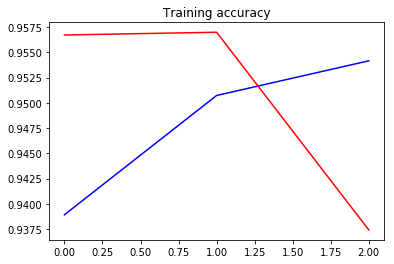

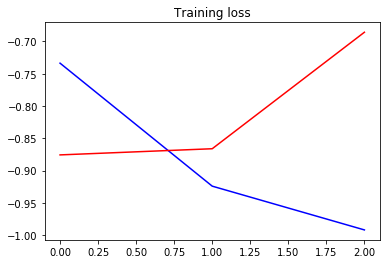

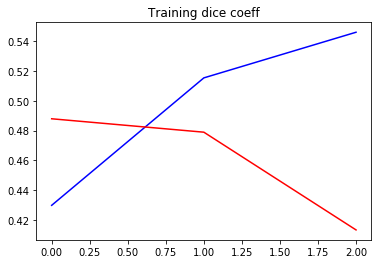

<Figure size 432x288 with 0 Axes>

In [24]:
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    dice_coeff = history.history['dice_coeff']
    val_dice_coeff = history.history['val_dice_coeff']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b-')
    plt.plot(epochs, val_acc, 'r-')
    plt.title('Training accuracy')
    plt.figure()
    plt.plot(epochs, loss, 'b-')
    plt.plot(epochs, val_loss, 'r-')
    plt.title('Training loss')
    plt.figure()
    plt.plot(epochs, dice_coeff, 'b-')
    plt.plot(epochs, val_dice_coeff, 'r-')
    plt.title('Training dice coeff')
    plt.figure()

    plt.show()
    
plot_training(history)